In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/STECH/time-series

/content/drive/MyDrive/STECH/time-series


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('FX_EURUSD, 1D.csv')

In [ ]:
cols = ['time','close']
df = df[cols]

In [ ]:
df = df.astype({'time':'datetime64'})

In [ ]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
df['date'] = pd.to_datetime(df['date'])
df.drop('time',axis=1,inplace=True)

In [ ]:
def adf_test(series):
  result = adfuller(series)
  print('ADF Statistics: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_test(df['close'])

ADF Statistics: -1.3882268949045666
p-value: 0.587907098008573
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


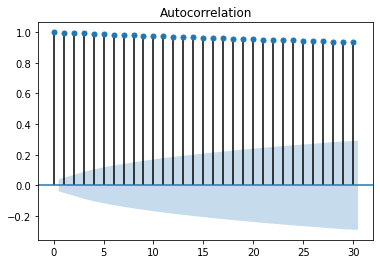

In [ ]:
acf_plot = plot_acf(df.close, lags=30)

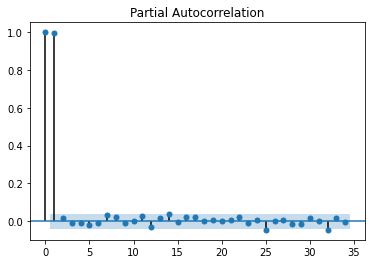

In [ ]:
pacf_plot = plot_pacf(df.close)

In [ ]:
df['close_diff_1'] = df['close'] - df['close'].shift(1)
df = df[1:]

In [ ]:
adf_test(df['close_diff_1'])

ADF Statistics: -14.760746220301035
p-value: 2.404462447708506e-27
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
result = df.copy()
result['date'] = pd.to_datetime(result['date'])
result.set_index('date',inplace=True)

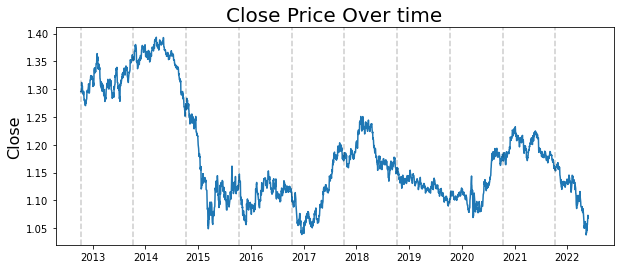

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(result.close)
plt.title('Close Price Over time', fontsize=20)
plt.ylabel('Close',fontsize=16)
for year in range(2012,2022):
  plt.axvline(pd.to_datetime(str(year) + '-10-10'), color='k', linestyle='--', alpha=0.2)

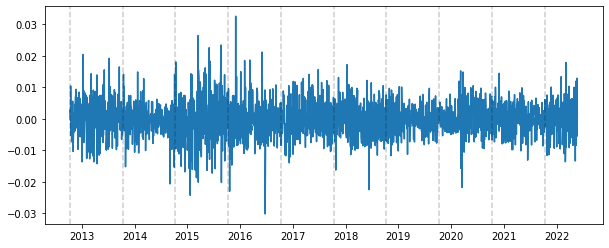

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(result.close_diff_1)
for year in range(2012,2022):
  plt.axvline(pd.to_datetime(str(year) + '-10-11'), color='k',linestyle='--',alpha=0.2)

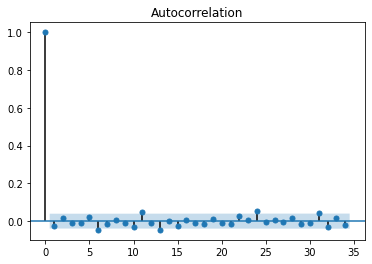

In [ ]:
acf_plot = plot_acf(df.close_diff_1)

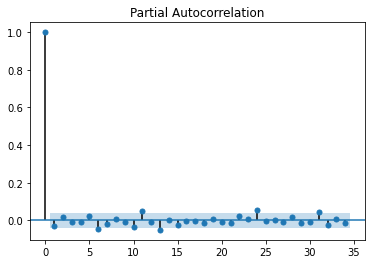

In [ ]:
pacf_plot = plot_pacf(df.close_diff_1)

In [ ]:
test_size = 0.2
train_samples = int((1-test_size)*len(df))
train_samples

1994

In [ ]:
train_data = df[:train_samples]
test_data = df[train_samples:]

In [ ]:
train_data

,close,date,close_diff_1
1,1.29538,2012-10-11,0.00270
2,1.29490,2012-10-14,-0.00048
3,1.30529,2012-10-15,0.01039
4,1.31188,2012-10-16,0.00659
5,1.30664,2012-10-17,-0.00524
...,...,...,...
1990,1.12057,2020-06-17,-0.00373
1991,1.11733,2020-06-18,-0.00324
1992,1.12601,2020-06-21,0.00868
1993,1.13073,2020-06-22,0.00472


In [ ]:
train_data.Timestamp = pd.to_datetime(train_data.date, format='%Y-%m-%d')
train_data.index = train_data.Timestamp
train_data = train_data.resample('D').sum()

test_data.Timestamp = pd.to_datetime(test_data.date, format='%Y-%m-%d')
test_data.index = test_data.Timestamp
test_data = test_data.resample('D').sum()

In [ ]:
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model_ARIMA = ARIMA(train_data['close'], order=(13,1,0))

In [ ]:
model_ARIMA_fit = model_ARIMA.fit()

In [ ]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 2812
Model:                ARIMA(13, 1, 0)   Log Likelihood                2786.686
Method:                       css-mle   S.D. of innovations              0.089
Date:                Sun, 29 May 2022   AIC                          -5543.371
Time:                        10:32:25   BIC                          -5454.247
Sample:                    10-12-2012   HQIC                         -5511.208
                         - 06-23-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.518e-05      0.000     -0.191      0.848      -0.001       0.000
ar.L1.D.close     -0.9821      0.019    -51.827      0.000      -1.019      -0.945
ar.L2.D.close     -0.9820      0.026    -37.936      0.000      -1.033      -0.931
ar.L3.D.close     -0.9747      0.031    -31.112      0.000      -1.036      -0.913
ar.L4.D.close     -0.9697      0.036    -26.970      0.000      -1.040      -0.899
ar.L5.D.close     -0.9752      0.040    -24.331      0.000      -1.054      -0.897
ar.L6.D.close     -0.9608      0.044    -21.857      0.000      -1.047      -0.875
ar.L7.D.close     -0.0364      0.047     -0.769      0.442      -0.129       0.056
ar.L8.D.close     -0.0326      0.046     -0.714      0.475      -0.122       0.057
ar.L9.D.close     -0.0444      0.042     -1.063      0.288      -0.126       0.037
ar.L10.D.close    -0.0469      0.037     -1.252      0.211      -0.120       0.026
ar.L11.D.close    -0.0471      0.032     -1.449      0.147      -0.111       0.017
ar.L12.D.close    -0.0531      0.027     -2.002      0.045      -0.105      -0.001
ar.L13.D.close    -0.0459      0.019     -2.435      0.015      -0.083      -0.009
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.6240           -0.7825j            1.0009           -0.1429
AR.2             0.6240           +0.7825j            1.0009            0.1429
AR.3             1.3845           -0.6586j            1.5332           -0.0707
AR.4             1.3845           +0.6586j            1.5332            0.0707
AR.5            -0.2229           -0.9766j            1.0017           -0.2857
AR.6            -0.2229           +0.9766j            1.0017            0.2857
AR.7             0.3290           -1.5031j            1.5387           -0.2157
AR.8             0.3290           +1.5031j            1.5387            0.2157
AR.9            -0.9119           -0.4390j            1.0121           -0.4286
AR.10           -0.9119           +0.4390j            1.0121            0.4286
AR.11           -0.9941           -1.1942j            1.5538           -0.3605
AR.12           -0.9941           +1.1942j            1.5538            0.3605
AR.13           -1.5732           -0.0000j            1.5732           -0.5000
------------------------------------------------------------------------------
"""

In [ ]:
pred = model_ARIMA_fit.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
residuals = test_data['close']-pred

In [ ]:
test_data['predicted_arima'] = pred

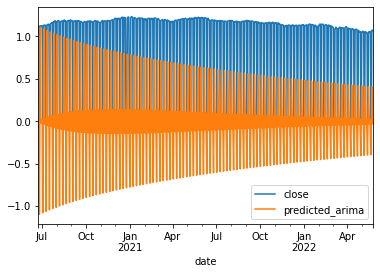

In [ ]:
test_data[['close','predicted_arima']].plot()

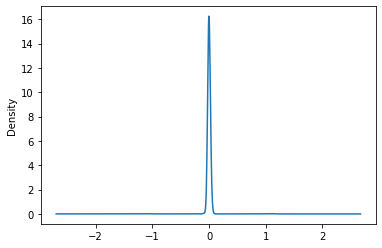

In [ ]:
model_ARIMA_fit.resid.plot(kind='kde')

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
model_ARMA = ARMA(train_data['close'], order=(3,0))

In [ ]:
model_ARMA_fit = model_ARMA.fit()

In [ ]:
model_ARMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2813
Model:                     ARMA(3, 0)   Log Likelihood               -1726.678
Method:                       css-mle   S.D. of innovations              0.447
Date:                Sun, 29 May 2022   AIC                           3463.356
Time:                        10:32:38   BIC                           3493.066
Sample:                    10-11-2012   HQIC                          3474.078
                         - 06-23-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8394      0.008    111.373      0.000       0.825       0.854
ar.L1.close     0.4215      0.019     22.395      0.000       0.385       0.458
ar.L2.close    -0.4777      0.018    -26.051      0.000      -0.514      -0.442
ar.L3.close    -0.0622      0.019     -3.304      0.001      -0.099      -0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4974           -1.2672j            1.3613           -0.1905
AR.2            0.4974           +1.2672j            1.3613            0.1905
AR.3           -8.6754           -0.0000j            8.6754           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
predict_ARMA = model_ARMA_fit.predict(start=pred_start_date, end=pred_end_date)
residuals_ARMA = test_data['close'] - predict_ARMA

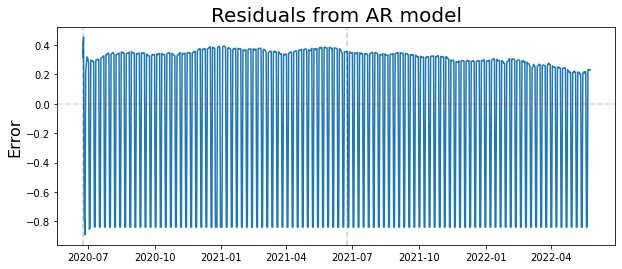

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2020, 2022):
  plt.axvline(pd.to_datetime(str(year) + '-06-24'), color='k', linestyle='--',alpha=0.2)

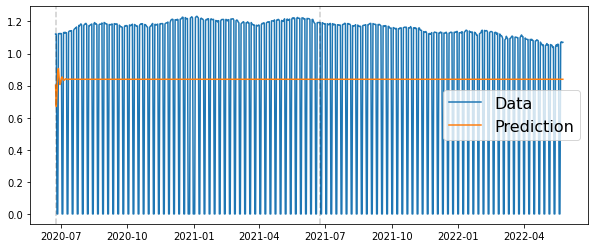

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(test_data['close'])
plt.plot(predict_ARMA)
plt.legend(('Data','Prediction'), fontsize=16)
for year in range(2020,2022):
  plt.axvline(pd.to_datetime(str(year)+'-06-24'),color='k',linestyle='--',alpha=0.2)

**Rolling Forecast**

In [ ]:
df.set_index('date',inplace=True)
df = df.resample('D').sum()

In [ ]:
#Predict 1 days in advance:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df[:end_date - timedelta(days=1)]
  model = ARMA(train_data['close'], order=(3,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred.loc[end_date]

In [ ]:
predictions_rolling1 = pd.DataFrame(data=predictions_rolling, columns=['close'])
predictions_rolling1

,close
2020-06-24,0.802794
2020-06-25,0.804059
2020-06-26,0.806141
2020-06-27,0.333194
2020-06-28,0.868817
...,...
2022-05-21,0.364526
2022-05-22,0.871234
2022-05-23,1.393493
2022-05-24,0.881740


In [ ]:
test_data['close']

date
2020-06-24    1.12174
2020-06-25    1.12162
2020-06-26    0.00000
2020-06-27    0.00000
2020-06-28    1.12412
               ...   
2022-05-21    0.00000
2022-05-22    1.06885
2022-05-23    1.07314
2022-05-24    1.06763
2022-05-25    1.06980
Freq: D, Name: close, Length: 701, dtype: float64

In [ ]:
residuals_rolling = test_data - predictions_rolling1

In [ ]:
residuals_rolling

,close,close_diff_1,predicted_arima
date,,,
2020-06-24,0.318946,NaN,NaN
2020-06-25,0.317561,NaN,NaN
2020-06-26,-0.806141,NaN,NaN
2020-06-27,-0.333194,NaN,NaN
2020-06-28,0.255303,NaN,NaN
...,...,...,...
2022-05-21,-0.364526,NaN,NaN
2022-05-22,0.197616,NaN,NaN
2022-05-23,-0.320353,NaN,NaN


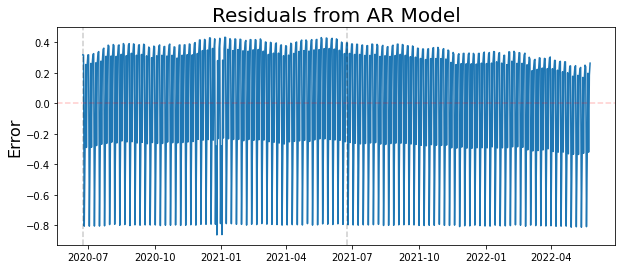

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling['close'])
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2020,2022):
    plt.axvline(pd.to_datetime(str(year)+'-06-24'), color='k', linestyle='--',alpha=0.2)

**Moving Average Model**

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
model = ARIMA(train_data['close'],order=(0,0,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 3513
Model:                     ARMA(0, 2)   Log Likelihood               -1892.224
Method:                       css-mle   S.D. of innovations              0.414
Date:                Sun, 29 May 2022   AIC                           3792.448
Time:                        10:43:18   BIC                           3817.105
Sample:                    10-11-2012   HQIC                          3801.246
                         - 05-24-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8372      0.004    204.628      0.000       0.829       0.845
ma.L1.close     0.2737      0.012     23.164      0.000       0.251       0.297
ma.L2.close    -0.6890      0.012    -58.812      0.000      -0.712      -0.666
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0224           +0.0000j            1.0224            0.5000
MA.2            1.4197           +0.0000j            1.4197            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
pred_start_date, pred_end_date

(Timestamp('2020-06-24 00:00:00', freq='D'),
 Timestamp('2022-05-25 00:00:00', freq='D'))

In [ ]:
predictions_MV = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
residuals_MV = test_data['close'] - predictions_MV

In [ ]:
len(test_data)

701

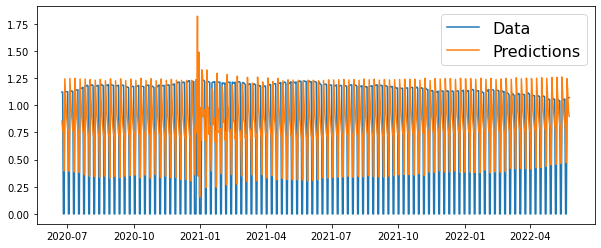

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(test_data['close'])
plt.plot(predictions_MV)
plt.legend(('Data','Predictions'), fontsize=16)